# Приблизительный план для визуализации
визуализируем логистическую регрессию



In [2]:
%pylab inline
figsize(10, 10)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


Populating the interactive namespace from numpy and matplotlib


# Генерируем искусственные данные (два гаусса)

In [3]:
numpy.random.seed(42)

In [4]:
n_samples = 20
dataset = numpy.random.normal(size=[n_samples, 2])
# метки (0 и 1)
labels = numpy.random.random(n_samples) > 0.5

In [5]:
# немного расплющил в нужную сторону 
dataset = dataset.dot([[1, -0.3], [-0.3, 1]])

# сдвигаю распределение, чтобы сигналы были правее и выше
dataset[:, 0] += 2 * labels - 1
dataset[:, 1] += 2 * labels - 1

In [6]:
xlims = -4, 4
ylims = -4, 4

## Задача логистической регрессии - разделить эти два класса при помощи линейного правила

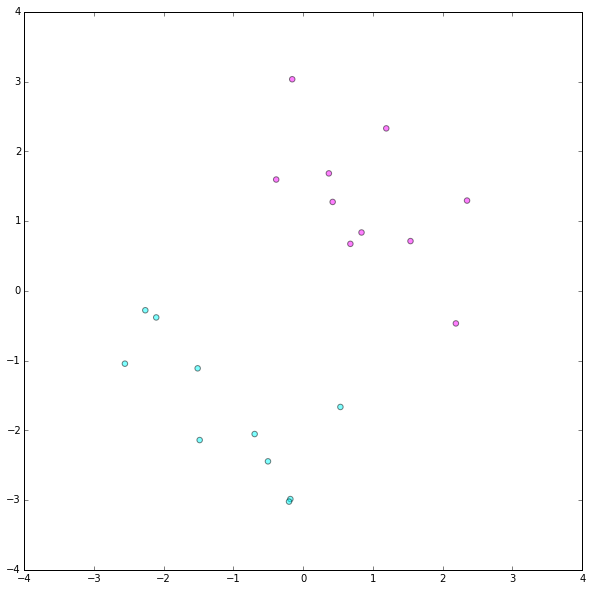

In [7]:
scatter(dataset[:, 0], dataset[:, 1], c=labels, alpha=0.5, cmap='cool', s=30)
_ = xlim(*xlims), ylim(*ylims)

In [61]:
# используем свою минималистичную логистическую регрессию
# у нее три параметра, которые надо уметь крутить: два коэффициента и один сдвиг (bias)
class LogisticRegression:
    def __init__(self, coeff1, coeff2, bias):
        self.bias = bias
        self.coeff = numpy.array([coeff1, coeff2])
        
    def decision_function(self, dataset):
        """
        Решающая функция (линейная + сдвиг)
        :param dataset: массив размера [n_samples, 2], каждая строка отвечает отдельному событию на плоскости
        """
        return dataset.dot(self.coeff.T) + self.bias
    
    
    def probability(self, dataset):
        """
        Вероятность - каждой входной точке приписываем вероятность, что она принадлежит классу 1
        Вычисляется при помощи логистической функции: 1 / (1 + exp(-pred))
        """
        decision = self.decision_function(dataset)
        return 1 / (1. + numpy.exp(-decision)) 
    
    def logloss_penalties(self, dataset):
        """
        Для каждого события
        """
        probabilities = self.probability(dataset)
        return -numpy.log(1 - probabilities), -numpy.log(probabilities)
    
    def decision_line(self):
        """
        Две точки для визуализации разделяющей прямой
        """
        assert sum(numpy.abs(self.coeff)) > 1e-7, 'too small coeffs'
        cx, cy = self.coeff
        if abs(self.coeff[0]) > abs(self.coeff[1]):
            y1, y2 = -10, 10
            x1 = - (cy * y1 + self.bias) / cx
            x2 = - (cy * y2 + self.bias) / cx
        else:
            x1, x2 = -10, 10
            y1 = - (cx * x1 + self.bias) / cy
            y2 = - (cx * x2 + self.bias) / cy
            
        return (x1, x2), (y1, y2)
    
    def normal_vector(self):
        """
        Помимо визуализации разделяющей кривой, надо показать ещё одну характеристику - 
        насколько быстро меняется градиент. Это можно показать при помощи вектора нормали.
        """
        c1, c2 = self.coeff
        p = - self.bias / (c1 ** 2 + c2 ** 2)
        x1 = c1 * p
        y1 = c2 * p
        x2 = x1 + c1
        y2 = y1 + c2
        return (x1, x2), (y1, y2)


In [62]:
# Для вычисления непрерывных функций заведем массив размера 100 * 100 точек
# Вычисляем значение в каждой точке и рисуем
gap = 0.5
grid_size = 100
x_points = numpy.linspace(xlims[0], xlims[1], grid_size)
y_points = numpy.linspace(ylims[0], ylims[1], grid_size)
grid_x, grid_y = numpy.meshgrid(x_points, y_points)
grid = numpy.c_[grid_x.ravel(), grid_y.ravel()]

# отдельная функция, чтобы что-то нарисовать на решетке
def plot_function_on_grid(values):
    pcolormesh(x_points, y_points, values.reshape([grid_size, grid_size]), alpha=0.2, cmap='cool', edgecolor='face')


# Режим первый.
Решающее правило выглядит как градиент в фотошопе. 
Можно даже его также рисовать, как градиент - точка отсчета + вектор, куда направлен

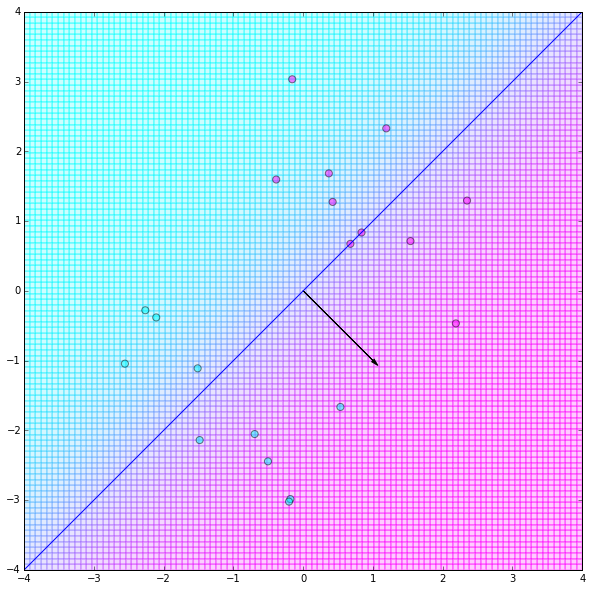

In [63]:
# три параметра регулируются
lr = LogisticRegression(1, -1, 0)

# вычислим вероятности и нарисуем на решетке
signal_probabilities = lr.probability(grid)
plot_function_on_grid(signal_probabilities)

# решающее правило
x_dl, y_dl = lr.decision_line()
plot(x_dl, y_dl)

# рисуем нормальный вектор
x_nv, y_nv = lr.normal_vector()
arrow(x_nv[0], y_nv[0], x_nv[1], y_nv[1], head_width=0.05, head_length=0.1, fc='k', ec='k')

# нарисуем точки исходной выборки
scatter(dataset[:, 0], dataset[:, 1], c=labels, alpha=0.5, cmap='cool', s=50)

_ = xlim(*xlims), ylim(*ylims)

# Вместе с 3d-видом
По вертикали откладывается логистическая функция потерь для каждого события.

(появляется второй график, на первом можно регулировать параметры логистической регрессии, на втором можно крутить камеру)

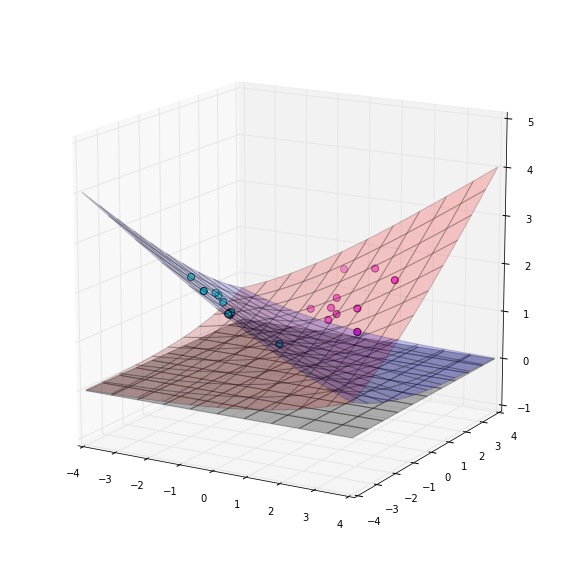

In [103]:
lr = LogisticRegression(-0.5, -0.5, 0)

ax = subplot(111, projection='3d')
_ = xlim(*xlims), ylim(*ylims)
ax.plot_surface(grid_x, grid_y, grid_x * 0,  
                facecolors=signal_probabilities.reshape(100,100)[:, :, None] * numpy.array([[[1, 0, -1]]]) * 0.0, alpha=0.3, cmap='cool')
# plot_function_on_grid(signal_probabilities)
# scatter(grid_x, grid_y, zs=grid_x * 0,  c=signal_probabilities, alpha=0.2, cmap='cool', edgecolor='face')
# нарисуем точки исходной выборки на соответствующих поверхностях
bck_loss, sig_loss = lr.logloss_penalties(dataset)
# высота - в зависимости от того, сигнал или шум, бурум первую или вторую компоненту
heights = numpy.where(labels==1, sig_loss, bck_loss)
scatter(dataset[:, 0], dataset[:, 1], zs=heights, c=labels, cmap='cool', s=50)

# вычисляем суммарный лосс (полную функцию потерь логистической регрессии):
# её надо куда-то вывести, чтобы показывать, что она увеличивается или уменьшается
loss_sum = sum(heights)

# рисуем лосс-функции (поверхности)
bck_loss, sig_loss = lr.logloss_penalties(grid)
ax.plot_surface(grid_x, grid_y, sig_loss.reshape(grid_size, grid_size), alpha=0.2, color='r')  
ax.plot_surface(grid_x, grid_y, bck_loss.reshape(grid_size, grid_size), alpha=0.2, color='b')  
ax.view_init(elev=15)


# Третий пункт
надо будет проиллюстрировать метод стозастического градиентного спуска, но код я подготовлю позже